In [1]:
import json
import os
import sys

import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

from koopmanlib.dictionary import PsiNN_obs
from koopmanlib.param_solver import KoopmanParametricDLSolver

from tqdm.keras import TqdmCallback

from koopmanlib.functions import *
from koopmanlib.target import KortewegDeVriesTarget

2024-08-05 23:42:44.554145: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-05 23:42:44.792594: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-05 23:42:45.684620: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.10.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.1/lib64:
2024-08-05 23:42:45.684941: W tensorflow/compiler/xla/stre

# Import Data

In [2]:
config_file = '/home/guoyue/Learning-Parametric-Koopman-Decompositions/examples/ParametricKoopman/kdv/config_kdv.json'

with open(config_file) as f:
    config = json.load(f)["sin"]

In [3]:
Nx = 256

In [4]:
# Set the size of the domain, and create the discretized grid.
L = 2 * np.pi
dx = L / (Nx - 1.0)
x = np.linspace(-np.pi, np.pi, Nx)
T = 0.01
def v_func(x, c):
    return np.exp(-25 * (x - c) ** 2)


c1, c2, c3 = -np.pi / 2, 0, np.pi / 2
v1 = v_func(x, c1).reshape(1, -1)
v2 = v_func(x, c2).reshape(1, -1)
v3 = v_func(x, c3).reshape(1, -1)

v_list = np.concatenate([v1, v2, v3], axis=0)
umax = 1
umin = -umax

target_dim = Nx
param_dim = 3

data_path = config["data_settings"]["data_path"]
weights_path = 'kdv_results/weights/check_vanilla'
figures_path = config["data_settings"]["figures_path"]
forcing_type = config["data_settings"]["forcing_type"]

n_psi_train = config["nn_settings"]["n_psi_train"]

kdv = KortewegDeVriesTarget(
    x=x, t_step=T, dim=Nx, param_dim=param_dim, forcing_type=forcing_type, v_list=v_list, L=L
)


kdv = KortewegDeVriesTarget(
    x=x, t_step=T, dim=Nx, param_dim=param_dim, forcing_type=forcing_type, v_list=v_list, L=L
)

In [5]:
n_psi = 1 + 1 + 1 + n_psi_train

dict_layer_size = config["nn_settings"]["dict_layer_size"]
K_layer_size = config["nn_settings"]["K_layer_size"]

pknn_epochs = config["nn_settings"]["pknn_epochs"]

In [6]:
print('dict_layer_size:', dict_layer_size)
print('K_layer_size:', K_layer_size)
print('pknn_epochs:', pknn_epochs)
print('n_psi:', n_psi)
print('Nx:', Nx)

dict_layer_size: [16, 16]
K_layer_size: [36, 36]
pknn_epochs: 500
n_psi: 6
Nx: 256


In [7]:
# Load data
dict_data = np.load(
    os.path.join(data_path, "data_kdv_" + forcing_type + "_"+str(Nx)+".npy"), allow_pickle=True
)

data_x = dict_data[()]["data_x"]
data_y = dict_data[()]["data_y"]
data_u = dict_data[()]["data_u"]

In [8]:
print('data_x shape:', data_x.shape)
print('data_y shape:', data_y.shape)
print('data_u shape:', data_u.shape)

data_x shape: (200000, 256)
data_y shape: (200000, 256)
data_u shape: (200000, 3)


# PK-NN

In [9]:
# # PK-NN
# dic_pk = PsiNN_obs(layer_sizes=dict_layer_size, n_psi_train=n_psi_train, dx=dx)
# from koopmanlib.K_structure import Model_K_u_Layer_One

# model_K_u = Model_K_u_Layer_One(layer_sizes=K_layer_size, n_psi=n_psi, activation="relu")

# solver_pk = KoopmanParametricDLSolver(
#     target_dim=target_dim, param_dim=param_dim, n_psi=n_psi, dic=dic_pk, model_K_u=model_K_u
# )

# model_pk, model_K_u_pred_pk = solver_pk.generate_model()

# model_pk.summary()

# zeros_data_y_train = tf.zeros_like(dic_pk(data_y))

# model_pk.compile(optimizer=Adam(0.001), loss="mse")

# lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor="loss",
#     factor=0.1,
#     patience=50,
#     verbose=0,
#     mode="auto",
#     min_delta=0.0001,
#     cooldown=0,
#     min_lr=1e-12,
# )
# checkpoint_path = os.path.join(weights_path, "pk_kdv_weights_" +str(Nx) + ".h5")
# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#         filepath=checkpoint_path,
#         monitor="val_loss",
#         save_best_only=True,
#         save_weights_only=True,
#         mode="min",
#         save_freq="epoch",
#     )

# # Define the TqdmCallback for progress bar
# tqdm_callback = TqdmCallback(verbose=1)

# callbacks = [lr_callback, checkpoint_callback, tqdm_callback]

# history_pk = model_pk.fit(
#     x=[data_x, data_y, data_u],
#     y=zeros_data_y_train,
#     validation_split=0.2,
#         epochs=pknn_epochs,
#         batch_size=200,
#         callbacks=callbacks,
#         verbose=0
#     )

# training_loss = history_pk.history['loss']
# validation_loss = history_pk.history['val_loss']
# best_epoch = validation_loss.index(min(validation_loss))
# best_loss_pk = training_loss[best_epoch]
# best_val_loss_pk = validation_loss[best_epoch]

# Vanilla

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
# Set the default data type to float64
tf.keras.backend.set_floatx('float64')

In [12]:
def create_vanilla_model(hidden_layers=[20], input_shape_x=(Nx,), input_shape_u=(param_dim,)):
    """
    Create a model with adjustable hidden layers.

    :param hidden_layers: List of integers, where each integer represents the number of units in a hidden layer.
    :param input_shape_x: Tuple representing the shape of input x.
    :param input_shape_u: Tuple representing the shape of input u.
    :return: Compiled Keras model.
    """
    # Define the input layers
    input_x = layers.Input(shape=input_shape_x)
    input_u = layers.Input(shape=input_shape_u)

    # Concatenate the inputs
    concatenated = layers.Concatenate()([input_x, input_u])

    # Add hidden layers based on the provided configuration
    x = concatenated
    for units in hidden_layers:
        x = layers.Dense(units, activation='relu')(x)

    # Output layer
    output_y = layers.Dense(Nx)(x)

    # Create the model
    model = models.Model(inputs=[input_x, input_u], outputs=output_y)

    # Print model summary to check the number of parameters
    model.summary()
    
    return model

In [15]:


# Create the model
model_vanilla = create_vanilla_model(hidden_layers=[1024,1024])
model_vanilla.compile(optimizer=Adam(), loss='mse')

# Print model summary to check the number of parameters
model_vanilla.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 259)          0           ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 1024)         266240      ['concatenate_1[0][0]']    

In [16]:
# Compile the model
from tensorflow.keras.optimizers import Adam
model_vanilla.compile(optimizer=Adam(0.001), loss="mse")

# Define the TqdmCallback for progress bar
tqdm_callback = TqdmCallback(verbose=1)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="loss",
    factor=0.1,
    patience=50,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=1e-12,
)

checkpoint_path = os.path.join(weights_path, "vanilla_kdv_weights_" +str(Nx) + ".h5")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
        mode="min",
        save_freq="epoch",
    )
history_vanilla = model_vanilla.fit([data_x, data_u], 
                                    data_y, 
                                    validation_split=0.2, 
                                    epochs=pknn_epochs, 
                                    batch_size=200, 
                                    callbacks=[lr_callback, tqdm_callback, checkpoint_callback],
                                    verbose=0)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

# Tracking  Problem

In [17]:
import time

from tqdm import tqdm

tau = 10

## Import reference

In [18]:
# Tracking problem
from scipy.optimize import minimize
# Testing reference
y0_track = np.zeros(shape=(Nx,)) + 0.2
Tsim_track = 10

traj_len_track = int(Tsim_track / T)

### Set piece-wise reference
soln_ref = np.zeros(shape=(traj_len_track, target_dim)) + 0.3

for i in range(soln_ref.shape[0]):
    if i > traj_len_track / 2:
        soln_ref[i, :] = 0.5
mass_ref = dx * tf.reshape(tf.math.reduce_sum(soln_ref, axis=-1), shape=(-1, 1))
momentum_ref = dx * tf.reshape(tf.math.reduce_sum(tf.square(soln_ref), axis=-1), shape=(-1, 1))

## PK-NN tracking

In [19]:
# def mpc_loss_pk(param, tau, ref_list, y0, B, lambda_param):
#     param = tf.reshape(param, shape=(int(param.shape[0] / param_dim), 1, param_dim))
#     loss_list = []
#     y0 = y0.reshape(1, -1)
#     psi_x = dic_pk(y0)

#     for i in range(tau):
#         psi_x = model_K_u_pred_pk([param[i], psi_x])
#         obs_next = psi_x @ B
#         loss_curr = tf.square(tf.norm(ref_list[i] - obs_next))
#         loss_list.append(loss_curr)

#     ref_loss = tf.reduce_sum(loss_list)
#     param_loss = lambda_param * tf.reduce_sum(tf.square(tf.norm(param, axis=-1)))

#     loss = ref_loss + param_loss

#     return loss


# def KoopmanMPC(y0, tau, traj_len, soln_ref, kdv_solver, B, loss, lambda_param):

#     bounds = []
#     for i in range(tau * param_dim):
#         bounds.append((-1, 1))

#     y0_mpc_loop_list = [y0]
#     opt_control_list = []

#     results_list = []

#     t_list = []

#     param_init = (
#             np.random.uniform(low=0, high=1, size=(tau * param_dim,)) * (umax - umin) + umin
#         )

#     # Wrap the loop with tqdm for a progress bar
#     for current_time in tqdm(range(traj_len - tau - 1), desc="Processing time steps"):

#         t1 = time.time()
#         results = minimize(
#             loss,
#             x0=param_init,
#             args=(
#                 tau,
#                 soln_ref[current_time + 1 : current_time + 1 + tau, :],
#                 y0_mpc_loop_list[-1],
#                 B,
#                 lambda_param,
#             ),
#             bounds=bounds,
#             method='L-BFGS-B'
#         )

#         t2 = time.time()

#         results_list.append(results)

#         param = results.x.reshape(tau, param_dim)[0]
#         param_init = results.x.reshape((tau * param_dim,))
#         soln_next = kdv_solver(y0_mpc_loop_list[-1], T, param)

#         y_next = soln_next.y.T[-1]
#         y0_mpc_loop_list.append(y_next)
#         opt_control_list.append(param)

#         print("*** current time ***", current_time)
#         print("optimize time: ", t2-t1)

#         t_list.append(t2-t1)

#     print("t mean: ", np.mean(t_list))

#     current_time = current_time + 1

#     # param_init = np.random.uniform(low=0, high=1, size=(tau * param_dim,)) * (umax - umin) + umin

#     results = minimize(
#         loss,
#         x0=param_init,
#         args=(
#             tau,
#             soln_ref[current_time + 1 : current_time + 1 + tau, :],
#             y0_mpc_loop_list[-1],
#             B,
#             lambda_param,
#         ),
#         bounds=bounds,
#     )
#     results_list.append(results)

#     param = results.x.reshape(tau, param_dim)
#     for param_curr in param:
#         soln_next = kdv_solver(y0_mpc_loop_list[-1], T, param_curr)
#         y_next = soln_next.y.T[-1]
#         y0_mpc_loop_list.append(y_next)
#         opt_control_list.append(param_curr)

#     opt_control_list = np.asarray(opt_control_list)
#     y0_mpc_loop_list = np.asarray(y0_mpc_loop_list)

#     return opt_control_list, y0_mpc_loop_list, results_list, t_list



In [20]:
# B_mass = dic_pk.generate_B_mass(mass_ref)
# B_momentum = dic_pk.generate_B_momentum(momentum_ref)
# ### Track mass
# tau = 10  # time horizon
# # lambda_param = 0.005
# # lambda_param = 0


# pk_opt_control_momentum_5, pk_kdv_opt_momentum_soln_5, pk_results_momentum_5, pk_t_list_momentum_5 = KoopmanMPC(
#     y0=y0_track,
#     tau=tau,
#     traj_len=traj_len_track,
#     soln_ref=momentum_ref,
#     kdv_solver=kdv.kdv_solution,
#     B=B_momentum,
#     loss=mpc_loss_pk,
#     lambda_param=0.005,
# )

In [21]:
# pk_kdv_opt_momentum_5 = dx * tf.reduce_sum(tf.square(pk_kdv_opt_momentum_soln_5), axis=-1)


## Vanilla tracking

In [22]:
def compute_mass(inputs):
    obs_mass = dx * tf.reshape(tf.math.reduce_sum(inputs, axis=-1), shape=(-1, 1))
    return obs_mass

def compute_momentum(inputs):
    obs_momentum = dx * tf.reshape(
        tf.math.reduce_sum(tf.square(inputs), axis=-1), shape=(-1, 1)
    )
    return obs_momentum

In [23]:
def mpc_loss_vanilla(param, tau, ref_list, y0, obs_func, lambda_param):
    param = tf.reshape(param, shape=(tau, 1, param_dim))
    loss_list = []
    y0 = y0.reshape(1, -1)
    y_list = [y0]

    for i in range(tau):
        y_next = model_vanilla([y_list[-1], param[i]])
        obs_next = obs_func(y_next)
        loss_curr = tf.square(tf.norm(ref_list[i] - obs_next))
        loss_list.append(loss_curr)

    ref_loss = tf.reduce_sum(loss_list)
    param_loss = lambda_param * tf.reduce_sum(tf.square(tf.norm(param, axis=-1)))

    loss = ref_loss + param_loss

    return loss

In [24]:

import time
def VanillaMPC(y0, tau, traj_len, soln_ref, kdv_solver, obs_func, loss, lambda_param):

    bounds = []
    for i in range(tau * param_dim):
        bounds.append((-1, 1))

    y0_mpc_loop_list = [y0]
    opt_control_list = []

    results_list = []

    t_list = []

    param_init = (
            np.random.uniform(low=0, high=1, size=(tau * param_dim,)) * (umax - umin) + umin
        )

    # Wrap the loop with tqdm for a progress bar
    for current_time in tqdm(range(traj_len - tau - 1), desc="Processing time steps"):

        t1 = time.time()
        results = minimize(
            loss,
            x0=param_init,
            args=(
                tau,
                soln_ref[current_time + 1 : current_time + 1 + tau, :],
                y0_mpc_loop_list[-1],
                obs_func,
                lambda_param,
            ),
            bounds=bounds,
            method='L-BFGS-B'
        )

        t2 = time.time()

        results_list.append(results)

        param = results.x.reshape(tau, param_dim)[0]
        param_init = results.x.reshape((tau * param_dim,))
        soln_next = kdv_solver(y0_mpc_loop_list[-1], T, param)

        y_next = soln_next.y.T[-1]
        y0_mpc_loop_list.append(y_next)
        opt_control_list.append(param)

        print("*** current time ***", current_time)
        print("optimize time: ", t2-t1)

        t_list.append(t2-t1)

    print("t mean: ", np.mean(t_list))

    current_time = current_time + 1

    # param_init = np.random.uniform(low=0, high=1, size=(tau * param_dim,)) * (umax - umin) + umin

    results = minimize(
        loss,
        x0=param_init,
        args=(
            tau,
            soln_ref[current_time + 1 : current_time + 1 + tau, :],
            y0_mpc_loop_list[-1],
            obs_func,
            lambda_param,
        ),
        bounds=bounds,
    )
    results_list.append(results)

    param = results.x.reshape(tau, param_dim)
    for param_curr in param:
        soln_next = kdv_solver(y0_mpc_loop_list[-1], T, param_curr)
        y_next = soln_next.y.T[-1]
        y0_mpc_loop_list.append(y_next)
        opt_control_list.append(param_curr)

    opt_control_list = np.asarray(opt_control_list)
    y0_mpc_loop_list = np.asarray(y0_mpc_loop_list)

    return opt_control_list, y0_mpc_loop_list, results_list, t_list



In [25]:
vanilla_opt_control_momentum_5, vanilla_kdv_opt_momentum_soln_5, vanilla_results_momentum_5, vanilla_t_list_momentum_5 = VanillaMPC(
    y0=y0_track,
    tau=tau,
    traj_len=traj_len_track,
    soln_ref=momentum_ref,
    kdv_solver=kdv.kdv_solution,
    obs_func=compute_momentum,
    loss=mpc_loss_vanilla,
    lambda_param=0.005,
)


*** current time *** 0
optimize time:  10.088644742965698


*** current time *** 1
optimize time:  3.7715842723846436


*** current time *** 2
optimize time:  1.2587816715240479


*** current time *** 3
optimize time:  3.77197527885437


*** current time *** 4
optimize time:  3.772984266281128


*** current time *** 5
optimize time:  3.59875226020813


*** current time *** 6
optimize time:  3.145524024963379


*** current time *** 7
optimize time:  3.1476399898529053


*** current time *** 8
optimize time:  3.1351208686828613


*** current time *** 9
optimize time:  3.152055025100708


*** current time *** 10
optimize time:  3.0904738903045654


*** current time *** 11
optimize time:  3.0668935775756836


*** current time *** 12
optimize time:  3.110353708267212


*** current time *** 13
optimize time:  3.111053943634033


*** current time *** 14
optimize time:  3.10699200630188


*** current time *** 15
optimize time:  3.1358537673950195


*** current time *** 16
optimize time:  3.20941424369812


*** current time *** 17
optimize time:  3.2041640281677246


*** current time *** 18
optimize time:  2.1536004543304443


*** current time *** 19
optimize time:  2.1412112712860107


*** current time *** 20
optimize time:  3.219261646270752


*** current time *** 21
optimize time:  3.205822229385376


*** current time *** 22
optimize time:  3.2138543128967285


*** current time *** 23
optimize time:  3.1886284351348877


*** current time *** 24
optimize time:  3.362055778503418


*** current time *** 25
optimize time:  4.608355522155762


*** current time *** 26
optimize time:  4.595605850219727


*** current time *** 27
optimize time:  3.3302910327911377


*** current time *** 28
optimize time:  3.2939791679382324


*** current time *** 29
optimize time:  4.0653204917907715


*** current time *** 30
optimize time:  4.540917873382568


*** current time *** 31
optimize time:  4.542852163314819


*** current time *** 32
optimize time:  4.041281461715698


*** current time *** 33
optimize time:  3.8167431354522705


*** current time *** 34
optimize time:  3.811290740966797


*** current time *** 35
optimize time:  3.8168694972991943


*** current time *** 36
optimize time:  3.1976099014282227


*** current time *** 37
optimize time:  3.20820689201355


*** current time *** 38
optimize time:  3.7490170001983643


*** current time *** 39
optimize time:  3.74214768409729


*** current time *** 40
optimize time:  2.3297111988067627


*** current time *** 41
optimize time:  3.126173734664917


*** current time *** 42
optimize time:  3.1480464935302734


*** current time *** 43
optimize time:  3.1384456157684326


*** current time *** 44
optimize time:  3.146501064300537


*** current time *** 45
optimize time:  3.1400890350341797


*** current time *** 46
optimize time:  3.1461377143859863


*** current time *** 47
optimize time:  3.1483218669891357


*** current time *** 48
optimize time:  3.1427462100982666


*** current time *** 49
optimize time:  3.1514551639556885


*** current time *** 50
optimize time:  3.1456074714660645


*** current time *** 51
optimize time:  3.155428647994995


*** current time *** 52
optimize time:  3.140615463256836


*** current time *** 53
optimize time:  3.1166088581085205


*** current time *** 54
optimize time:  14.573070526123047


*** current time *** 55
optimize time:  3.1115217208862305


*** current time *** 56
optimize time:  3.123538017272949


*** current time *** 57
optimize time:  3.148653268814087


*** current time *** 58
optimize time:  3.228278875350952


*** current time *** 59
optimize time:  3.2297210693359375


*** current time *** 60
optimize time:  3.2313637733459473


*** current time *** 61
optimize time:  3.220621109008789


*** current time *** 62
optimize time:  3.2212018966674805


*** current time *** 63
optimize time:  3.2184557914733887


*** current time *** 64
optimize time:  3.3489739894866943


*** current time *** 65
optimize time:  5.23045539855957


*** current time *** 66
optimize time:  3.264883279800415


*** current time *** 67
optimize time:  3.203050136566162


*** current time *** 68
optimize time:  3.204380989074707


*** current time *** 69
optimize time:  3.235172986984253


*** current time *** 70
optimize time:  2.1368467807769775


*** current time *** 71
optimize time:  4.641058921813965


*** current time *** 72
optimize time:  4.025672197341919


*** current time *** 73
optimize time:  3.1942245960235596


*** current time *** 74
optimize time:  3.1847610473632812


*** current time *** 75
optimize time:  3.240452289581299


*** current time *** 76
optimize time:  3.235483407974243


*** current time *** 77
optimize time:  3.23429274559021


*** current time *** 78
optimize time:  3.2306435108184814


*** current time *** 79
optimize time:  3.8396904468536377


*** current time *** 80
optimize time:  3.3956167697906494


*** current time *** 81
optimize time:  3.2265586853027344


*** current time *** 82
optimize time:  3.8305530548095703


*** current time *** 83
optimize time:  3.367431163787842


*** current time *** 84
optimize time:  5.090083599090576


*** current time *** 85
optimize time:  5.077383279800415


*** current time *** 86
optimize time:  5.052351951599121


*** current time *** 87
optimize time:  5.057908773422241


*** current time *** 88
optimize time:  4.379191875457764


*** current time *** 89
optimize time:  2.561401605606079


*** current time *** 90
optimize time:  3.841399908065796


*** current time *** 91
optimize time:  3.838538408279419


*** current time *** 92
optimize time:  3.843263864517212


*** current time *** 93
optimize time:  3.1725778579711914


*** current time *** 94
optimize time:  3.186666488647461


*** current time *** 95
optimize time:  3.195122480392456


*** current time *** 96
optimize time:  3.2093310356140137


*** current time *** 97
optimize time:  2.0797653198242188


*** current time *** 98
optimize time:  3.1493523120880127


*** current time *** 99
optimize time:  3.165900945663452


*** current time *** 100
optimize time:  2.101022243499756


*** current time *** 101
optimize time:  3.1637814044952393


*** current time *** 102
optimize time:  3.164064407348633


*** current time *** 103
optimize time:  3.1690080165863037


*** current time *** 104
optimize time:  3.165872812271118


*** current time *** 105
optimize time:  3.170130491256714


*** current time *** 106
optimize time:  3.183145523071289


*** current time *** 107
optimize time:  1.0553159713745117


*** current time *** 108
optimize time:  3.14778208732605


*** current time *** 109
optimize time:  3.156026601791382


*** current time *** 110
optimize time:  2.1040639877319336


*** current time *** 111
optimize time:  3.1220974922180176


*** current time *** 112
optimize time:  3.1230037212371826


*** current time *** 113
optimize time:  3.1018340587615967


*** current time *** 114
optimize time:  3.1219351291656494


*** current time *** 115
optimize time:  3.144678831100464


*** current time *** 116
optimize time:  3.215104818344116


*** current time *** 117
optimize time:  1.0754992961883545


*** current time *** 118
optimize time:  3.204697370529175


*** current time *** 119
optimize time:  1.0665922164916992


*** current time *** 120
optimize time:  2.1381399631500244


*** current time *** 121
optimize time:  3.2080860137939453


*** current time *** 122
optimize time:  1.2467875480651855


*** current time *** 123
optimize time:  3.8385696411132812


*** current time *** 124
optimize time:  3.8481624126434326


*** current time *** 125
optimize time:  3.845278024673462


*** current time *** 126
optimize time:  1.2846064567565918


*** current time *** 127
optimize time:  3.69927978515625


*** current time *** 128
optimize time:  1.522693157196045


*** current time *** 129
optimize time:  4.54973292350769


*** current time *** 130
optimize time:  4.394153594970703


*** current time *** 131
optimize time:  1.5146782398223877


*** current time *** 132
optimize time:  2.987556219100952


*** current time *** 133
optimize time:  3.792505979537964


*** current time *** 134
optimize time:  1.1986773014068604


*** current time *** 135
optimize time:  3.239823579788208


*** current time *** 136
optimize time:  3.8070735931396484


*** current time *** 137
optimize time:  1.267545461654663


*** current time *** 138
optimize time:  3.8056318759918213


*** current time *** 139
optimize time:  1.2744758129119873


*** current time *** 140
optimize time:  2.5351433753967285


*** current time *** 141
optimize time:  2.5393612384796143


*** current time *** 142
optimize time:  3.799828290939331


*** current time *** 143
optimize time:  1.271151065826416


*** current time *** 144
optimize time:  1.267463207244873


*** current time *** 145
optimize time:  3.7957417964935303


*** current time *** 146
optimize time:  3.802485466003418


*** current time *** 147
optimize time:  1.1898131370544434


*** current time *** 148
optimize time:  2.1826093196868896


*** current time *** 149
optimize time:  3.259204387664795


*** current time *** 150
optimize time:  1.095649242401123


*** current time *** 151
optimize time:  3.432934045791626


*** current time *** 152
optimize time:  1.0955264568328857


*** current time *** 153
optimize time:  1.0938043594360352


*** current time *** 154
optimize time:  3.281294584274292


*** current time *** 155
optimize time:  3.2589433193206787


*** current time *** 156
optimize time:  3.2606592178344727


*** current time *** 157
optimize time:  1.0895144939422607


*** current time *** 158
optimize time:  3.2596940994262695


*** current time *** 159
optimize time:  1.0876076221466064


*** current time *** 160
optimize time:  1.0854465961456299


*** current time *** 161
optimize time:  3.266376256942749


*** current time *** 162
optimize time:  1.0896952152252197


*** current time *** 163
optimize time:  1.0830285549163818


*** current time *** 164
optimize time:  2.162473440170288


*** current time *** 165
optimize time:  3.2349374294281006


*** current time *** 166
optimize time:  1.0874595642089844


*** current time *** 167
optimize time:  3.2655258178710938


*** current time *** 168
optimize time:  1.0998952388763428


*** current time *** 169
optimize time:  1.0885117053985596


*** current time *** 170
optimize time:  1.0883324146270752


*** current time *** 171
optimize time:  1.0977685451507568


*** current time *** 172
optimize time:  3.258359909057617


*** current time *** 173
optimize time:  1.0864145755767822


*** current time *** 174
optimize time:  2.189399480819702


*** current time *** 175
optimize time:  3.2797021865844727


*** current time *** 176
optimize time:  1.096506118774414


*** current time *** 177
optimize time:  3.2785513401031494


*** current time *** 178
optimize time:  1.0935943126678467


*** current time *** 179
optimize time:  3.2749924659729004


*** current time *** 180
optimize time:  1.0896220207214355


*** current time *** 181
optimize time:  1.0952491760253906


*** current time *** 182
optimize time:  1.0936729907989502


*** current time *** 183
optimize time:  1.0872340202331543


*** current time *** 184
optimize time:  3.265014886856079


*** current time *** 185
optimize time:  1.0966432094573975


*** current time *** 186
optimize time:  1.0913472175598145


*** current time *** 187
optimize time:  1.0768322944641113


*** current time *** 188
optimize time:  1.092933177947998


*** current time *** 189
optimize time:  3.261845111846924


*** current time *** 190
optimize time:  1.1034810543060303


*** current time *** 191
optimize time:  1.0905637741088867


*** current time *** 192
optimize time:  1.1424720287322998


*** current time *** 193
optimize time:  1.0803158283233643


*** current time *** 194
optimize time:  1.0931239128112793


*** current time *** 195
optimize time:  3.266817569732666


*** current time *** 196
optimize time:  1.092094898223877


*** current time *** 197
optimize time:  1.094398021697998


*** current time *** 198
optimize time:  3.895551919937134


*** current time *** 199
optimize time:  3.8929903507232666


*** current time *** 200
optimize time:  3.8935866355895996


*** current time *** 201
optimize time:  1.3036127090454102


*** current time *** 202
optimize time:  1.3089780807495117


*** current time *** 203
optimize time:  1.1179323196411133


*** current time *** 204
optimize time:  1.1112797260284424


*** current time *** 205
optimize time:  3.3278307914733887


*** current time *** 206
optimize time:  1.1124701499938965


*** current time *** 207
optimize time:  1.1443583965301514


*** current time *** 208
optimize time:  1.1111772060394287


*** current time *** 209
optimize time:  1.1109082698822021


*** current time *** 210
optimize time:  1.1107163429260254


*** current time *** 211
optimize time:  1.1085100173950195


*** current time *** 212
optimize time:  3.3326587677001953


*** current time *** 213
optimize time:  1.3421509265899658


*** current time *** 214
optimize time:  1.5168108940124512


*** current time *** 215
optimize time:  1.0850026607513428


*** current time *** 216
optimize time:  1.0880358219146729


*** current time *** 217
optimize time:  1.0852878093719482


*** current time *** 218
optimize time:  1.087829828262329


*** current time *** 219
optimize time:  1.0827832221984863


*** current time *** 220
optimize time:  3.2367300987243652


*** current time *** 221
optimize time:  1.0978877544403076


*** current time *** 222
optimize time:  1.0840246677398682


*** current time *** 223
optimize time:  1.0839943885803223


*** current time *** 224
optimize time:  1.0951642990112305


*** current time *** 225
optimize time:  1.0832786560058594


*** current time *** 226
optimize time:  1.0829119682312012


*** current time *** 227
optimize time:  1.0816705226898193


*** current time *** 228
optimize time:  3.4567830562591553


*** current time *** 229
optimize time:  1.652024745941162


*** current time *** 230
optimize time:  1.3005685806274414


*** current time *** 231
optimize time:  1.303565502166748


*** current time *** 232
optimize time:  1.3024547100067139


*** current time *** 233
optimize time:  1.286802053451538


*** current time *** 234
optimize time:  1.301170825958252


*** current time *** 235
optimize time:  1.3022446632385254


*** current time *** 236
optimize time:  1.301339864730835


*** current time *** 237
optimize time:  1.2802841663360596


*** current time *** 238
optimize time:  1.3013029098510742


*** current time *** 239
optimize time:  1.0859549045562744


*** current time *** 240
optimize time:  1.0989012718200684


*** current time *** 241
optimize time:  1.0739221572875977


*** current time *** 242
optimize time:  1.1310036182403564


*** current time *** 243
optimize time:  1.0734248161315918


*** current time *** 244
optimize time:  3.207872152328491


*** current time *** 245
optimize time:  3.279486894607544


*** current time *** 246
optimize time:  1.091111421585083


*** current time *** 247
optimize time:  3.289935350418091


*** current time *** 248
optimize time:  1.1010420322418213


*** current time *** 249
optimize time:  1.0932869911193848


*** current time *** 250
optimize time:  1.2959814071655273


*** current time *** 251
optimize time:  1.2721922397613525


*** current time *** 252
optimize time:  1.0757155418395996


*** current time *** 253
optimize time:  1.0752778053283691


*** current time *** 254
optimize time:  1.0767316818237305


*** current time *** 255
optimize time:  1.08378005027771


*** current time *** 256
optimize time:  1.0955119132995605


*** current time *** 257
optimize time:  1.0966768264770508


*** current time *** 258
optimize time:  1.1073050498962402


*** current time *** 259
optimize time:  1.097020149230957


*** current time *** 260
optimize time:  1.2778751850128174


*** current time *** 261
optimize time:  1.0781993865966797


*** current time *** 262
optimize time:  1.0855579376220703


*** current time *** 263
optimize time:  1.0797710418701172


*** current time *** 264
optimize time:  1.0788586139678955


*** current time *** 265
optimize time:  1.080047845840454


*** current time *** 266
optimize time:  1.0755627155303955


*** current time *** 267
optimize time:  1.299947738647461


*** current time *** 268
optimize time:  2.599330186843872


*** current time *** 269
optimize time:  3.8928256034851074


*** current time *** 270
optimize time:  1.08719801902771


*** current time *** 271
optimize time:  1.1467387676239014


*** current time *** 272
optimize time:  1.2998013496398926


*** current time *** 273
optimize time:  1.299602746963501


*** current time *** 274
optimize time:  1.2993547916412354


*** current time *** 275
optimize time:  1.1030380725860596


*** current time *** 276
optimize time:  1.0985450744628906


*** current time *** 277
optimize time:  1.0919220447540283


*** current time *** 278
optimize time:  1.2913577556610107


*** current time *** 279
optimize time:  1.0739364624023438


*** current time *** 280
optimize time:  1.2938263416290283


*** current time *** 281
optimize time:  1.7072174549102783


*** current time *** 282
optimize time:  1.7041618824005127


*** current time *** 283
optimize time:  1.695387363433838


*** current time *** 284
optimize time:  1.7216651439666748


*** current time *** 285
optimize time:  1.7005963325500488


*** current time *** 286
optimize time:  1.6967663764953613


*** current time *** 287
optimize time:  1.2760310173034668


*** current time *** 288
optimize time:  1.2742152214050293


*** current time *** 289
optimize time:  1.2760004997253418


*** current time *** 290
optimize time:  3.7829301357269287


*** current time *** 291
optimize time:  1.2678656578063965


*** current time *** 292
optimize time:  1.2686266899108887


*** current time *** 293
optimize time:  3.7907276153564453


*** current time *** 294
optimize time:  3.782090902328491


*** current time *** 295
optimize time:  1.263636589050293


*** current time *** 296
optimize time:  3.7963366508483887


*** current time *** 297
optimize time:  1.2660999298095703


*** current time *** 298
optimize time:  3.780808925628662


*** current time *** 299
optimize time:  1.2606399059295654


*** current time *** 300
optimize time:  1.288292407989502


*** current time *** 301
optimize time:  1.2874298095703125


*** current time *** 302
optimize time:  1.2853097915649414


*** current time *** 303
optimize time:  1.2842578887939453


*** current time *** 304
optimize time:  1.2941827774047852


*** current time *** 305
optimize time:  1.29127836227417


*** current time *** 306
optimize time:  1.2623748779296875


*** current time *** 307
optimize time:  1.2815475463867188


*** current time *** 308
optimize time:  1.2784907817840576


*** current time *** 309
optimize time:  1.2780702114105225


*** current time *** 310
optimize time:  1.2431330680847168


*** current time *** 311
optimize time:  1.053788661956787


*** current time *** 312
optimize time:  1.0485901832580566


*** current time *** 313
optimize time:  1.0415709018707275


*** current time *** 314
optimize time:  1.0622777938842773


*** current time *** 315
optimize time:  1.0435962677001953


*** current time *** 316
optimize time:  1.0424084663391113


*** current time *** 317
optimize time:  1.2340474128723145


*** current time *** 318
optimize time:  1.2623436450958252


*** current time *** 319
optimize time:  1.0936057567596436


*** current time *** 320
optimize time:  1.0846455097198486


*** current time *** 321
optimize time:  1.0967705249786377


*** current time *** 322
optimize time:  1.1095497608184814


*** current time *** 323
optimize time:  1.0962328910827637


*** current time *** 324
optimize time:  1.0971055030822754


*** current time *** 325
optimize time:  1.1088979244232178


*** current time *** 326
optimize time:  1.0995090007781982


*** current time *** 327
optimize time:  1.0992894172668457


*** current time *** 328
optimize time:  1.0983641147613525


*** current time *** 329
optimize time:  1.0997765064239502


*** current time *** 330
optimize time:  1.0995213985443115


*** current time *** 331
optimize time:  1.0772514343261719


*** current time *** 332
optimize time:  1.0792090892791748


*** current time *** 333
optimize time:  1.0767786502838135


*** current time *** 334
optimize time:  1.073160171508789


*** current time *** 335
optimize time:  1.0785305500030518


*** current time *** 336
optimize time:  1.0732691287994385


*** current time *** 337
optimize time:  1.0914883613586426


*** current time *** 338
optimize time:  1.089949607849121


*** current time *** 339
optimize time:  1.090625286102295


*** current time *** 340
optimize time:  1.0887889862060547


*** current time *** 341
optimize time:  1.0535674095153809


*** current time *** 342
optimize time:  1.0574777126312256


*** current time *** 343
optimize time:  1.056983232498169


*** current time *** 344
optimize time:  1.0791385173797607


*** current time *** 345
optimize time:  1.0658435821533203


*** current time *** 346
optimize time:  1.0504183769226074


*** current time *** 347
optimize time:  1.0519697666168213


*** current time *** 348
optimize time:  1.0899858474731445


*** current time *** 349
optimize time:  1.251830816268921


*** current time *** 350
optimize time:  1.2652006149291992


*** current time *** 351
optimize time:  1.2650699615478516


*** current time *** 352
optimize time:  1.2640626430511475


*** current time *** 353
optimize time:  1.2442450523376465


*** current time *** 354
optimize time:  1.2865681648254395


*** current time *** 355
optimize time:  1.2415907382965088


*** current time *** 356
optimize time:  1.2644944190979004


*** current time *** 357
optimize time:  1.2682368755340576


*** current time *** 358
optimize time:  1.2452497482299805


*** current time *** 359
optimize time:  1.2671163082122803


*** current time *** 360
optimize time:  1.0675952434539795


*** current time *** 361
optimize time:  1.0745339393615723


*** current time *** 362
optimize time:  1.297698974609375


*** current time *** 363
optimize time:  1.2777037620544434


*** current time *** 364
optimize time:  1.1679766178131104


*** current time *** 365
optimize time:  1.2629883289337158


*** current time *** 366
optimize time:  1.2734510898590088


*** current time *** 367
optimize time:  1.2598440647125244


*** current time *** 368
optimize time:  1.2779223918914795


*** current time *** 369
optimize time:  1.255450963973999


*** current time *** 370
optimize time:  1.279120683670044


*** current time *** 371
optimize time:  1.241795301437378


*** current time *** 372
optimize time:  1.0568821430206299


*** current time *** 373
optimize time:  1.0539336204528809


*** current time *** 374
optimize time:  1.0487756729125977


*** current time *** 375
optimize time:  1.0456342697143555


*** current time *** 376
optimize time:  1.0455329418182373


*** current time *** 377
optimize time:  1.0940132141113281


*** current time *** 378
optimize time:  1.0476353168487549


*** current time *** 379
optimize time:  1.0418620109558105


*** current time *** 380
optimize time:  1.0364654064178467


*** current time *** 381
optimize time:  1.0329952239990234


*** current time *** 382
optimize time:  1.0389037132263184


*** current time *** 383
optimize time:  1.0634806156158447


*** current time *** 384
optimize time:  1.058011531829834


*** current time *** 385
optimize time:  3.1823596954345703


*** current time *** 386
optimize time:  1.0541715621948242


*** current time *** 387
optimize time:  1.090550184249878


*** current time *** 388
optimize time:  1.0789482593536377


*** current time *** 389
optimize time:  3.23572039604187


*** current time *** 390
optimize time:  1.0635712146759033


*** current time *** 391
optimize time:  1.0705945491790771


*** current time *** 392
optimize time:  3.1804897785186768


*** current time *** 393
optimize time:  1.0573346614837646


*** current time *** 394
optimize time:  3.177950859069824


*** current time *** 395
optimize time:  1.0680792331695557


*** current time *** 396
optimize time:  1.0701541900634766


*** current time *** 397
optimize time:  1.0697548389434814


*** current time *** 398
optimize time:  1.0904860496520996


*** current time *** 399
optimize time:  1.0728199481964111


*** current time *** 400
optimize time:  3.282949924468994


*** current time *** 401
optimize time:  1.726844072341919


*** current time *** 402
optimize time:  5.212010860443115


*** current time *** 403
optimize time:  1.115971565246582


*** current time *** 404
optimize time:  1.083571434020996


*** current time *** 405
optimize time:  1.064199686050415


*** current time *** 406
optimize time:  3.2260799407958984


*** current time *** 407
optimize time:  1.0922412872314453


*** current time *** 408
optimize time:  1.093315601348877


*** current time *** 409
optimize time:  1.091146469116211


*** current time *** 410
optimize time:  1.2557439804077148


*** current time *** 411
optimize time:  1.2841863632202148


*** current time *** 412
optimize time:  1.2782816886901855


*** current time *** 413
optimize time:  3.8211638927459717


*** current time *** 414
optimize time:  1.2840502262115479


*** current time *** 415
optimize time:  1.2585294246673584


*** current time *** 416
optimize time:  1.2841618061065674


*** current time *** 417
optimize time:  1.2596542835235596


*** current time *** 418
optimize time:  1.2667882442474365


*** current time *** 419
optimize time:  1.2775495052337646


*** current time *** 420
optimize time:  1.092236042022705


*** current time *** 421
optimize time:  1.2843012809753418


*** current time *** 422
optimize time:  3.8660199642181396


*** current time *** 423
optimize time:  1.22442626953125


*** current time *** 424
optimize time:  4.384483814239502


*** current time *** 425
optimize time:  1.7573583126068115


*** current time *** 426
optimize time:  5.310100078582764


*** current time *** 427
optimize time:  1.8311710357666016


*** current time *** 428
optimize time:  4.355259656906128


*** current time *** 429
optimize time:  4.610955715179443


*** current time *** 430
optimize time:  1.6918911933898926


*** current time *** 431
optimize time:  1.6211867332458496


*** current time *** 432
optimize time:  1.5234386920928955


*** current time *** 433
optimize time:  4.038457155227661


*** current time *** 434
optimize time:  1.4591596126556396


*** current time *** 435
optimize time:  1.7445275783538818


*** current time *** 436
optimize time:  1.5122952461242676


*** current time *** 437
optimize time:  4.1613850593566895


*** current time *** 438
optimize time:  1.3096578121185303


*** current time *** 439
optimize time:  1.286712646484375


*** current time *** 440
optimize time:  1.3171935081481934


*** current time *** 441
optimize time:  3.9603826999664307


*** current time *** 442
optimize time:  2.737553119659424


*** current time *** 443
optimize time:  1.3379266262054443


*** current time *** 444
optimize time:  1.3224914073944092


*** current time *** 445
optimize time:  1.3062481880187988


*** current time *** 446
optimize time:  1.3270483016967773


*** current time *** 447
optimize time:  1.312692403793335


*** current time *** 448
optimize time:  1.3133976459503174


*** current time *** 449
optimize time:  1.3158373832702637


*** current time *** 450
optimize time:  1.309769868850708


*** current time *** 451
optimize time:  1.3671696186065674


*** current time *** 452
optimize time:  1.281376600265503


*** current time *** 453
optimize time:  1.305248498916626


*** current time *** 454
optimize time:  1.3276731967926025


*** current time *** 455
optimize time:  1.4196183681488037


*** current time *** 456
optimize time:  1.863074541091919


*** current time *** 457
optimize time:  1.5922393798828125


*** current time *** 458
optimize time:  1.2845227718353271


*** current time *** 459
optimize time:  1.2591297626495361


*** current time *** 460
optimize time:  1.4262332916259766


*** current time *** 461
optimize time:  1.3240253925323486


*** current time *** 462
optimize time:  1.390310287475586


*** current time *** 463
optimize time:  4.431568145751953


*** current time *** 464
optimize time:  1.5573487281799316


*** current time *** 465
optimize time:  1.2973995208740234


*** current time *** 466
optimize time:  1.3019239902496338


*** current time *** 467
optimize time:  2.5469727516174316


*** current time *** 468
optimize time:  4.433894872665405


*** current time *** 469
optimize time:  1.2288613319396973


*** current time *** 470
optimize time:  1.2689788341522217


*** current time *** 471
optimize time:  1.2771944999694824


*** current time *** 472
optimize time:  1.7360203266143799


*** current time *** 473
optimize time:  1.2938439846038818


*** current time *** 474
optimize time:  1.5347614288330078


*** current time *** 475
optimize time:  1.5319783687591553


*** current time *** 476
optimize time:  1.2990765571594238


*** current time *** 477
optimize time:  3.9549198150634766


*** current time *** 478
optimize time:  1.3248062133789062


*** current time *** 479
optimize time:  1.3261497020721436


*** current time *** 480
optimize time:  1.2926301956176758


*** current time *** 481
optimize time:  1.3124587535858154


*** current time *** 482
optimize time:  1.3159079551696777


*** current time *** 483
optimize time:  1.2917673587799072


*** current time *** 484
optimize time:  1.3044607639312744


*** current time *** 485
optimize time:  1.284986972808838


*** current time *** 486
optimize time:  1.2845444679260254


*** current time *** 487
optimize time:  1.2939424514770508


*** current time *** 488
optimize time:  1.3047335147857666


*** current time *** 489
optimize time:  3.812962532043457


*** current time *** 490
optimize time:  1.4164855480194092


*** current time *** 491
optimize time:  89.61546564102173


*** current time *** 492
optimize time:  120.2566487789154


*** current time *** 493
optimize time:  190.444641828537


*** current time *** 494
optimize time:  201.8470916748047


*** current time *** 495
optimize time:  190.06209683418274


*** current time *** 496
optimize time:  154.7552411556244


*** current time *** 497
optimize time:  178.1731686592102


*** current time *** 498
optimize time:  154.80096554756165


*** current time *** 499
optimize time:  246.52762460708618


*** current time *** 500
optimize time:  88.46137809753418


*** current time *** 501
optimize time:  28.887640714645386


*** current time *** 502
optimize time:  68.47563791275024


*** current time *** 503
optimize time:  103.40219783782959


*** current time *** 504
optimize time:  33.41619682312012


*** current time *** 505
optimize time:  44.01911950111389


*** current time *** 506
optimize time:  61.772438287734985


*** current time *** 507
optimize time:  36.569875955581665


*** current time *** 508
optimize time:  56.464755058288574


*** current time *** 509
optimize time:  43.429214000701904


*** current time *** 510
optimize time:  137.35573363304138


*** current time *** 511
optimize time:  62.96117329597473


*** current time *** 512
optimize time:  45.23195719718933


*** current time *** 513
optimize time:  19.28314518928528


*** current time *** 514
optimize time:  41.76078486442566


*** current time *** 515
optimize time:  54.619537353515625


*** current time *** 516
optimize time:  42.96319031715393


*** current time *** 517
optimize time:  81.30849409103394


*** current time *** 518
optimize time:  77.77168393135071


*** current time *** 519
optimize time:  95.22578382492065


*** current time *** 520
optimize time:  131.64465403556824


*** current time *** 521
optimize time:  85.70760083198547


*** current time *** 522
optimize time:  56.37085962295532


*** current time *** 523
optimize time:  54.794368743896484


*** current time *** 524
optimize time:  179.8141062259674


*** current time *** 525
optimize time:  81.95068097114563


*** current time *** 526
optimize time:  73.01347851753235


*** current time *** 527
optimize time:  38.88024950027466


*** current time *** 528
optimize time:  21.965128660202026


*** current time *** 529
optimize time:  33.42463994026184


*** current time *** 530
optimize time:  134.55471324920654


*** current time *** 531
optimize time:  101.68306422233582


*** current time *** 532
optimize time:  36.228044271469116


*** current time *** 533
optimize time:  42.53778600692749


*** current time *** 534
optimize time:  26.399726390838623


*** current time *** 535
optimize time:  54.93460488319397


*** current time *** 536
optimize time:  19.649053812026978


*** current time *** 537
optimize time:  74.41318345069885


*** current time *** 538
optimize time:  69.316246509552


*** current time *** 539
optimize time:  48.870917558670044


*** current time *** 540
optimize time:  57.291316986083984


*** current time *** 541
optimize time:  46.11811089515686


*** current time *** 542
optimize time:  62.41682004928589


*** current time *** 543
optimize time:  48.44751477241516


*** current time *** 544
optimize time:  41.79867482185364


*** current time *** 545
optimize time:  84.89651727676392


*** current time *** 546
optimize time:  56.1579384803772


*** current time *** 547
optimize time:  61.5148823261261


*** current time *** 548
optimize time:  67.99160289764404


*** current time *** 549
optimize time:  47.917096853256226


*** current time *** 550
optimize time:  108.27761912345886


*** current time *** 551
optimize time:  121.84344148635864


*** current time *** 552
optimize time:  94.54459190368652


*** current time *** 553
optimize time:  154.09606504440308


*** current time *** 554
optimize time:  112.31488275527954


*** current time *** 555
optimize time:  45.620240211486816


*** current time *** 556
optimize time:  72.39212846755981


*** current time *** 557
optimize time:  115.63018441200256


*** current time *** 558
optimize time:  52.47388291358948


*** current time *** 559
optimize time:  92.18022656440735


*** current time *** 560
optimize time:  103.79918694496155


*** current time *** 561
optimize time:  81.23123621940613


*** current time *** 562
optimize time:  159.38793396949768


*** current time *** 563
optimize time:  130.57667112350464


*** current time *** 564
optimize time:  74.9207010269165


*** current time *** 565
optimize time:  100.11442804336548


*** current time *** 566
optimize time:  97.96439170837402


*** current time *** 567
optimize time:  119.31035351753235


*** current time *** 568
optimize time:  117.93732261657715


*** current time *** 569
optimize time:  118.94136548042297


*** current time *** 570
optimize time:  82.36073923110962


*** current time *** 571
optimize time:  172.39777278900146


*** current time *** 572
optimize time:  162.8764910697937


*** current time *** 573
optimize time:  96.47831678390503


*** current time *** 574
optimize time:  50.52954816818237


*** current time *** 575
optimize time:  89.13969159126282


*** current time *** 576
optimize time:  81.84219908714294


*** current time *** 577
optimize time:  87.71894717216492


*** current time *** 578
optimize time:  108.08994913101196


*** current time *** 579
optimize time:  119.01045823097229


*** current time *** 580
optimize time:  79.53274035453796


*** current time *** 581
optimize time:  131.39224076271057


*** current time *** 582
optimize time:  122.49654459953308


*** current time *** 583
optimize time:  67.00173783302307


*** current time *** 584
optimize time:  94.43259525299072


*** current time *** 585
optimize time:  119.3580231666565


*** current time *** 586
optimize time:  96.86651921272278


*** current time *** 587
optimize time:  76.27286887168884


*** current time *** 588
optimize time:  42.20534133911133


*** current time *** 589
optimize time:  17.952707767486572


*** current time *** 590
optimize time:  41.83084797859192


*** current time *** 591
optimize time:  128.8317973613739


*** current time *** 592
optimize time:  82.35306286811829


*** current time *** 593
optimize time:  38.89741015434265


*** current time *** 594
optimize time:  90.77062916755676


*** current time *** 595
optimize time:  109.34411644935608


*** current time *** 596
optimize time:  94.08941292762756


*** current time *** 597
optimize time:  95.4807481765747


*** current time *** 598
optimize time:  91.57598543167114


*** current time *** 599
optimize time:  95.01139807701111


*** current time *** 600
optimize time:  89.57562112808228


*** current time *** 601
optimize time:  44.5503945350647


*** current time *** 602
optimize time:  94.67421793937683


*** current time *** 603
optimize time:  114.40919423103333


*** current time *** 604
optimize time:  133.0367181301117


*** current time *** 605
optimize time:  90.65321230888367


*** current time *** 606
optimize time:  182.59598231315613


*** current time *** 607
optimize time:  76.42308402061462


*** current time *** 608
optimize time:  3.830176591873169


*** current time *** 609
optimize time:  3.915252685546875


*** current time *** 610
optimize time:  4.050723314285278


*** current time *** 611
optimize time:  3.823901891708374


*** current time *** 612
optimize time:  16.512731075286865


*** current time *** 613
optimize time:  3.7584383487701416


*** current time *** 614
optimize time:  3.9168965816497803


*** current time *** 615
optimize time:  4.505527973175049


*** current time *** 616
optimize time:  3.757214069366455


*** current time *** 617
optimize time:  3.8065223693847656


*** current time *** 618
optimize time:  3.9057412147521973


*** current time *** 619
optimize time:  4.149121522903442


*** current time *** 620
optimize time:  3.725552797317505


*** current time *** 621
optimize time:  3.7371320724487305


*** current time *** 622
optimize time:  4.1510114669799805


*** current time *** 623
optimize time:  3.7567484378814697


*** current time *** 624
optimize time:  3.826568365097046


*** current time *** 625
optimize time:  3.837383270263672


*** current time *** 626
optimize time:  3.8011674880981445


*** current time *** 627
optimize time:  3.796640396118164


*** current time *** 628
optimize time:  3.9721291065216064


*** current time *** 629
optimize time:  3.80519962310791


*** current time *** 630
optimize time:  3.9945621490478516


*** current time *** 631
optimize time:  3.74678111076355


*** current time *** 632
optimize time:  3.7245750427246094


*** current time *** 633
optimize time:  4.9440224170684814


*** current time *** 634
optimize time:  3.705305576324463


*** current time *** 635
optimize time:  3.9262423515319824


*** current time *** 636
optimize time:  3.8078806400299072


*** current time *** 637
optimize time:  3.8761513233184814


*** current time *** 638
optimize time:  3.8218472003936768


*** current time *** 639
optimize time:  4.22899866104126


*** current time *** 640
optimize time:  3.7426674365997314


*** current time *** 641
optimize time:  3.8206801414489746


*** current time *** 642
optimize time:  3.845432996749878


*** current time *** 643
optimize time:  3.782212018966675


*** current time *** 644
optimize time:  4.073837518692017


*** current time *** 645
optimize time:  1.2892088890075684


*** current time *** 646
optimize time:  3.945866346359253


*** current time *** 647
optimize time:  3.8681983947753906


*** current time *** 648
optimize time:  3.818650007247925


*** current time *** 649
optimize time:  3.7894766330718994


*** current time *** 650
optimize time:  3.7670698165893555


*** current time *** 651
optimize time:  4.198116302490234


*** current time *** 652
optimize time:  3.8042802810668945


*** current time *** 653
optimize time:  3.752018451690674


*** current time *** 654
optimize time:  3.806267499923706


*** current time *** 655
optimize time:  3.6844260692596436


*** current time *** 656
optimize time:  3.7472240924835205


*** current time *** 657
optimize time:  3.7215263843536377


*** current time *** 658
optimize time:  3.726639747619629


*** current time *** 659
optimize time:  3.180389881134033


*** current time *** 660
optimize time:  3.9115312099456787


*** current time *** 661
optimize time:  1.2421653270721436


*** current time *** 662
optimize time:  3.719879388809204


*** current time *** 663
optimize time:  1.2432231903076172


*** current time *** 664
optimize time:  3.823798418045044


*** current time *** 665
optimize time:  3.836435079574585


*** current time *** 666
optimize time:  3.7172977924346924


*** current time *** 667
optimize time:  3.7838828563690186


*** current time *** 668
optimize time:  1.2504181861877441


*** current time *** 669
optimize time:  3.8278963565826416


*** current time *** 670
optimize time:  3.937499523162842


*** current time *** 671
optimize time:  3.8206934928894043


*** current time *** 672
optimize time:  3.8917298316955566


*** current time *** 673
optimize time:  3.7879154682159424


*** current time *** 674
optimize time:  3.7790966033935547


*** current time *** 675
optimize time:  3.8716464042663574


*** current time *** 676
optimize time:  3.8304455280303955


*** current time *** 677
optimize time:  3.7598867416381836


*** current time *** 678
optimize time:  3.860539436340332


*** current time *** 679
optimize time:  3.7595088481903076


*** current time *** 680
optimize time:  3.7431368827819824


*** current time *** 681
optimize time:  3.7352962493896484


*** current time *** 682
optimize time:  3.7762739658355713


*** current time *** 683
optimize time:  3.7631239891052246


*** current time *** 684
optimize time:  3.8161425590515137


*** current time *** 685
optimize time:  3.8095526695251465


*** current time *** 686
optimize time:  3.718632221221924


*** current time *** 687
optimize time:  3.95335054397583


*** current time *** 688
optimize time:  3.815300941467285


*** current time *** 689
optimize time:  3.7622804641723633


*** current time *** 690
optimize time:  3.882962465286255


*** current time *** 691
optimize time:  3.767594575881958


*** current time *** 692
optimize time:  3.7551751136779785


*** current time *** 693
optimize time:  3.750521421432495


*** current time *** 694
optimize time:  3.7674343585968018


*** current time *** 695
optimize time:  3.7502686977386475


*** current time *** 696
optimize time:  3.7930424213409424


*** current time *** 697
optimize time:  3.8757882118225098


*** current time *** 698
optimize time:  3.745410442352295


*** current time *** 699
optimize time:  3.8131730556488037


*** current time *** 700
optimize time:  1.456967830657959


*** current time *** 701
optimize time:  4.364913702011108


*** current time *** 702
optimize time:  4.3968346118927


*** current time *** 703
optimize time:  4.2814247608184814


*** current time *** 704
optimize time:  3.769192695617676


*** current time *** 705
optimize time:  1.26100492477417


*** current time *** 706
optimize time:  3.765615463256836


*** current time *** 707
optimize time:  4.331836223602295


*** current time *** 708
optimize time:  1.4488067626953125


*** current time *** 709
optimize time:  4.506460666656494


*** current time *** 710
optimize time:  3.73903226852417


*** current time *** 711
optimize time:  1.2424495220184326


*** current time *** 712
optimize time:  3.723499298095703


*** current time *** 713
optimize time:  3.7251369953155518


*** current time *** 714
optimize time:  1.244598388671875


*** current time *** 715
optimize time:  3.716268301010132


*** current time *** 716
optimize time:  3.7331604957580566


*** current time *** 717
optimize time:  3.754533290863037


*** current time *** 718
optimize time:  3.7485504150390625


*** current time *** 719
optimize time:  4.087758779525757


*** current time *** 720
optimize time:  4.415109157562256


*** current time *** 721
optimize time:  3.743208408355713


*** current time *** 722
optimize time:  3.8275015354156494


*** current time *** 723
optimize time:  3.822575807571411


*** current time *** 724
optimize time:  3.7835640907287598


*** current time *** 725
optimize time:  3.792036771774292


*** current time *** 726
optimize time:  3.823153495788574


*** current time *** 727
optimize time:  3.7187187671661377


*** current time *** 728
optimize time:  1.2583339214324951


*** current time *** 729
optimize time:  3.7900164127349854


*** current time *** 730
optimize time:  3.943995714187622


*** current time *** 731
optimize time:  1.4405698776245117


*** current time *** 732
optimize time:  3.8259246349334717


*** current time *** 733
optimize time:  3.8120205402374268


*** current time *** 734
optimize time:  3.820338010787964


*** current time *** 735
optimize time:  3.828158378601074


*** current time *** 736
optimize time:  4.031742334365845


*** current time *** 737
optimize time:  3.8919427394866943


*** current time *** 738
optimize time:  1.5326993465423584


*** current time *** 739
optimize time:  3.9470789432525635


*** current time *** 740
optimize time:  3.9420254230499268


*** current time *** 741
optimize time:  3.7532308101654053


*** current time *** 742
optimize time:  3.8057312965393066


*** current time *** 743
optimize time:  3.7767107486724854


*** current time *** 744
optimize time:  3.9461660385131836


*** current time *** 745
optimize time:  3.897961139678955


*** current time *** 746
optimize time:  3.714574098587036


*** current time *** 747
optimize time:  4.432071208953857


*** current time *** 748
optimize time:  3.7537856101989746


*** current time *** 749
optimize time:  4.032329082489014


*** current time *** 750
optimize time:  3.772308111190796


*** current time *** 751
optimize time:  3.8120059967041016


*** current time *** 752
optimize time:  3.828245162963867


*** current time *** 753
optimize time:  3.7503175735473633


*** current time *** 754
optimize time:  4.004054546356201


*** current time *** 755
optimize time:  1.282585859298706


*** current time *** 756
optimize time:  3.8864150047302246


*** current time *** 757
optimize time:  3.8128201961517334


*** current time *** 758
optimize time:  3.8295960426330566


*** current time *** 759
optimize time:  3.7585830688476562


*** current time *** 760
optimize time:  3.8171651363372803


*** current time *** 761
optimize time:  1.257866382598877


*** current time *** 762
optimize time:  4.464818000793457


*** current time *** 763
optimize time:  4.444260120391846


*** current time *** 764
optimize time:  4.424098968505859


*** current time *** 765
optimize time:  3.8675358295440674


*** current time *** 766
optimize time:  3.8402178287506104


*** current time *** 767
optimize time:  3.7272889614105225


*** current time *** 768
optimize time:  1.2425599098205566


*** current time *** 769
optimize time:  3.7156338691711426


*** current time *** 770
optimize time:  1.2370491027832031


*** current time *** 771
optimize time:  4.017046213150024


*** current time *** 772
optimize time:  3.7837324142456055


*** current time *** 773
optimize time:  3.7983195781707764


*** current time *** 774
optimize time:  3.781477928161621


*** current time *** 775
optimize time:  1.2447106838226318


*** current time *** 776
optimize time:  3.7679672241210938


*** current time *** 777
optimize time:  3.807297706604004


*** current time *** 778
optimize time:  3.884929656982422


*** current time *** 779
optimize time:  1.2599270343780518


*** current time *** 780
optimize time:  3.7871174812316895


*** current time *** 781
optimize time:  3.7832586765289307


*** current time *** 782
optimize time:  3.913151741027832


*** current time *** 783
optimize time:  3.727081775665283


*** current time *** 784
optimize time:  1.2391541004180908


*** current time *** 785
optimize time:  3.8158109188079834


*** current time *** 786
optimize time:  3.7744197845458984


*** current time *** 787
optimize time:  3.769660711288452


*** current time *** 788
optimize time:  3.7880823612213135


*** current time *** 789
optimize time:  3.844362497329712


*** current time *** 790
optimize time:  1.2749886512756348


*** current time *** 791
optimize time:  3.781231164932251


*** current time *** 792
optimize time:  3.914979934692383


*** current time *** 793
optimize time:  3.825094223022461


*** current time *** 794
optimize time:  3.8797056674957275


*** current time *** 795
optimize time:  3.828639507293701


*** current time *** 796
optimize time:  4.517894744873047


*** current time *** 797
optimize time:  3.853928565979004


*** current time *** 798
optimize time:  3.7588298320770264


*** current time *** 799
optimize time:  3.8589184284210205


*** current time *** 800
optimize time:  3.9566242694854736


*** current time *** 801
optimize time:  3.8581063747406006


*** current time *** 802
optimize time:  3.844670295715332


*** current time *** 803
optimize time:  3.8319642543792725


*** current time *** 804
optimize time:  1.2679851055145264


*** current time *** 805
optimize time:  3.823223829269409


*** current time *** 806
optimize time:  3.7137935161590576


*** current time *** 807
optimize time:  1.259275197982788


*** current time *** 808
optimize time:  3.886068105697632


*** current time *** 809
optimize time:  3.8086588382720947


*** current time *** 810
optimize time:  3.814821481704712


*** current time *** 811
optimize time:  4.002500772476196


*** current time *** 812
optimize time:  1.2439560890197754


*** current time *** 813
optimize time:  3.882241725921631


*** current time *** 814
optimize time:  1.3029673099517822


*** current time *** 815
optimize time:  3.7445857524871826


*** current time *** 816
optimize time:  3.818401575088501


*** current time *** 817
optimize time:  1.261948823928833


*** current time *** 818
optimize time:  3.9603729248046875


*** current time *** 819
optimize time:  3.9219186305999756


*** current time *** 820
optimize time:  1.4044287204742432


*** current time *** 821
optimize time:  4.081537485122681


*** current time *** 822
optimize time:  3.7064177989959717


*** current time *** 823
optimize time:  3.9801151752471924


*** current time *** 824
optimize time:  1.262542486190796


*** current time *** 825
optimize time:  4.0023980140686035


*** current time *** 826
optimize time:  3.781813859939575


*** current time *** 827
optimize time:  3.8168742656707764


*** current time *** 828
optimize time:  3.756493330001831


*** current time *** 829
optimize time:  3.822017192840576


*** current time *** 830
optimize time:  3.9279725551605225


*** current time *** 831
optimize time:  3.842270612716675


*** current time *** 832
optimize time:  1.4763975143432617


*** current time *** 833
optimize time:  3.8185389041900635


*** current time *** 834
optimize time:  3.7793591022491455


*** current time *** 835
optimize time:  1.2477922439575195


*** current time *** 836
optimize time:  3.7365598678588867


*** current time *** 837
optimize time:  3.7882564067840576


*** current time *** 838
optimize time:  3.687370777130127


*** current time *** 839
optimize time:  3.8661093711853027


*** current time *** 840
optimize time:  3.7818222045898438


*** current time *** 841
optimize time:  3.7780890464782715


*** current time *** 842
optimize time:  4.80956768989563


*** current time *** 843
optimize time:  3.783722400665283


*** current time *** 844
optimize time:  3.8257269859313965


*** current time *** 845
optimize time:  3.678879499435425


*** current time *** 846
optimize time:  3.7230031490325928


*** current time *** 847
optimize time:  3.9618749618530273


*** current time *** 848
optimize time:  4.418298721313477


*** current time *** 849
optimize time:  3.718634843826294


*** current time *** 850
optimize time:  3.7223572731018066


*** current time *** 851
optimize time:  3.8087317943573


*** current time *** 852
optimize time:  3.7868456840515137


*** current time *** 853
optimize time:  3.9353559017181396


*** current time *** 854
optimize time:  3.770259141921997


*** current time *** 855
optimize time:  1.2929418087005615


*** current time *** 856
optimize time:  1.2764289379119873


*** current time *** 857
optimize time:  3.9320385456085205


*** current time *** 858
optimize time:  3.920283079147339


*** current time *** 859
optimize time:  3.8089351654052734


*** current time *** 860
optimize time:  3.787916898727417


*** current time *** 861
optimize time:  1.2822258472442627


*** current time *** 862
optimize time:  3.8466763496398926


*** current time *** 863
optimize time:  3.845811128616333


*** current time *** 864
optimize time:  3.8719425201416016


*** current time *** 865
optimize time:  3.893012285232544


*** current time *** 866
optimize time:  3.861374855041504


*** current time *** 867
optimize time:  3.8434953689575195


*** current time *** 868
optimize time:  3.6432502269744873


*** current time *** 869
optimize time:  3.7141778469085693


*** current time *** 870
optimize time:  4.423772096633911


*** current time *** 871
optimize time:  1.2414355278015137


*** current time *** 872
optimize time:  3.7985680103302


*** current time *** 873
optimize time:  3.739283800125122


*** current time *** 874
optimize time:  3.748279333114624


*** current time *** 875
optimize time:  3.7712130546569824


*** current time *** 876
optimize time:  3.7529044151306152


*** current time *** 877
optimize time:  3.874964714050293


*** current time *** 878
optimize time:  1.6223852634429932


*** current time *** 879
optimize time:  3.7886312007904053


*** current time *** 880
optimize time:  3.8069803714752197


*** current time *** 881
optimize time:  2.614150285720825


*** current time *** 882
optimize time:  3.792025566101074


*** current time *** 883
optimize time:  3.7855191230773926


*** current time *** 884
optimize time:  3.761554479598999


*** current time *** 885
optimize time:  3.8425545692443848


*** current time *** 886
optimize time:  3.722895860671997


*** current time *** 887
optimize time:  3.815178394317627


*** current time *** 888
optimize time:  3.8307785987854004


*** current time *** 889
optimize time:  3.904585123062134


*** current time *** 890
optimize time:  3.830949068069458


*** current time *** 891
optimize time:  1.2664484977722168


*** current time *** 892
optimize time:  3.789055585861206


*** current time *** 893
optimize time:  3.7652645111083984


*** current time *** 894
optimize time:  4.181601524353027


*** current time *** 895
optimize time:  3.815913200378418


*** current time *** 896
optimize time:  3.9422683715820312


*** current time *** 897
optimize time:  3.7617440223693848


*** current time *** 898
optimize time:  3.744307518005371


*** current time *** 899
optimize time:  3.7134413719177246


*** current time *** 900
optimize time:  3.759136915206909


*** current time *** 901
optimize time:  1.262364387512207


*** current time *** 902
optimize time:  1.2605540752410889


*** current time *** 903
optimize time:  3.766336441040039


*** current time *** 904
optimize time:  1.2813103199005127


*** current time *** 905
optimize time:  1.2963626384735107


*** current time *** 906
optimize time:  1.340836763381958


*** current time *** 907
optimize time:  3.7411694526672363


*** current time *** 908
optimize time:  3.729090929031372


*** current time *** 909
optimize time:  3.8626387119293213


*** current time *** 910
optimize time:  3.8713197708129883


*** current time *** 911
optimize time:  3.86710786819458


*** current time *** 912
optimize time:  3.8392817974090576


*** current time *** 913
optimize time:  3.968658447265625


*** current time *** 914
optimize time:  3.839992046356201


*** current time *** 915
optimize time:  3.799246072769165


*** current time *** 916
optimize time:  4.044517517089844


*** current time *** 917
optimize time:  3.759664535522461


*** current time *** 918
optimize time:  3.785433769226074


*** current time *** 919
optimize time:  3.8006503582000732


*** current time *** 920
optimize time:  3.7906811237335205


*** current time *** 921
optimize time:  1.2620904445648193


*** current time *** 922
optimize time:  3.771279811859131


*** current time *** 923
optimize time:  4.1762354373931885


*** current time *** 924
optimize time:  1.49721097946167


*** current time *** 925
optimize time:  4.233731508255005


*** current time *** 926
optimize time:  3.7752974033355713


*** current time *** 927
optimize time:  1.2562792301177979


*** current time *** 928
optimize time:  3.7625157833099365


*** current time *** 929
optimize time:  3.845659017562866


*** current time *** 930
optimize time:  3.7608108520507812


*** current time *** 931
optimize time:  3.707218647003174


*** current time *** 932
optimize time:  1.413926362991333


*** current time *** 933
optimize time:  4.43102502822876


*** current time *** 934
optimize time:  4.587911128997803


*** current time *** 935
optimize time:  1.280857801437378


*** current time *** 936
optimize time:  4.504435777664185


*** current time *** 937
optimize time:  4.134309768676758


*** current time *** 938
optimize time:  3.718491315841675


*** current time *** 939
optimize time:  3.750303268432617


*** current time *** 940
optimize time:  3.76088809967041


*** current time *** 941
optimize time:  3.7478058338165283


*** current time *** 942
optimize time:  3.807192325592041


*** current time *** 943
optimize time:  4.056211471557617


*** current time *** 944
optimize time:  3.772056818008423


*** current time *** 945
optimize time:  1.4908013343811035


*** current time *** 946
optimize time:  4.155056476593018


*** current time *** 947
optimize time:  3.828848123550415


*** current time *** 948
optimize time:  1.278200387954712


*** current time *** 949
optimize time:  3.8372151851654053


*** current time *** 950
optimize time:  3.8261470794677734


*** current time *** 951
optimize time:  3.7457027435302734


*** current time *** 952
optimize time:  3.9107308387756348


*** current time *** 953
optimize time:  4.59573221206665


*** current time *** 954
optimize time:  4.519569158554077


*** current time *** 955
optimize time:  4.141362428665161


*** current time *** 956
optimize time:  3.8250064849853516


*** current time *** 957
optimize time:  3.8316361904144287


*** current time *** 958
optimize time:  3.814176321029663


*** current time *** 959
optimize time:  3.996699810028076


*** current time *** 960
optimize time:  3.7650413513183594


*** current time *** 961
optimize time:  3.692702054977417


*** current time *** 962
optimize time:  3.8094680309295654


*** current time *** 963
optimize time:  3.891819715499878


*** current time *** 964
optimize time:  3.821626663208008


*** current time *** 965
optimize time:  3.8278920650482178


*** current time *** 966
optimize time:  3.845731496810913


*** current time *** 967
optimize time:  3.810131788253784


*** current time *** 968
optimize time:  3.666046380996704


*** current time *** 969
optimize time:  3.739887237548828


*** current time *** 970
optimize time:  3.7520735263824463


*** current time *** 971
optimize time:  3.734647274017334


*** current time *** 972
optimize time:  3.7354624271392822


*** current time *** 973
optimize time:  4.40869402885437


*** current time *** 974
optimize time:  3.951782464981079


*** current time *** 975
optimize time:  1.2868270874023438


*** current time *** 976
optimize time:  3.8993442058563232


*** current time *** 977
optimize time:  4.098279237747192


*** current time *** 978
optimize time:  3.715845823287964


*** current time *** 979
optimize time:  3.7154693603515625


*** current time *** 980
optimize time:  1.242241621017456


*** current time *** 981
optimize time:  3.801332473754883


*** current time *** 982
optimize time:  1.3151464462280273


*** current time *** 983
optimize time:  3.7084193229675293


*** current time *** 984
optimize time:  3.6977341175079346


*** current time *** 985
optimize time:  3.8130757808685303


*** current time *** 986
optimize time:  3.957669258117676


*** current time *** 987
optimize time:  3.7234930992126465



Processing time steps: 100%|██████████| 989/989 [4:25:32<00:00, 16.11s/it]

*** current time *** 988
optimize time:  3.72782039642334
t mean:  12.895163281742555


In [26]:
vanilla_kdv_opt_momentum_5 = dx * tf.reduce_sum(tf.square(vanilla_kdv_opt_momentum_soln_5), axis=-1)


# Plot results

In [27]:
# Plot setting
linear_curve = "gold"
bilinear_curve = "yellowgreen"
pk_curve = "mediumpurple"
vanilla_curve = "cornflowerblue"


linear_no_penalty_color = "darkorange"
bilinear_no_penalty_color = "forestgreen"
pk_no_penalty_color = "rebeccapurple"
vanilla_no_penalty_color = "blue"


ref_color = "black"
exact_color = "darkred"



label_font = 24
ticks_font = 22
legend_font = 24
linewidth = 2.5
title_font = 16

linear_linestyle = "dashdot"
bilinear_linestyle = "dotted"
pk_linestyle = "solid"
vanilla_linestyle = 'dashed'

linear_marker = 's'
bilinear_marker = 'o'
pk_marker = '*'
vanilla_marker = 'p'

linear_markevery = 70
bilinear_markevery = 80
pk_markevery = 50
vanilla_markevery = 60

Text(0, 0.5, 'Momentum')

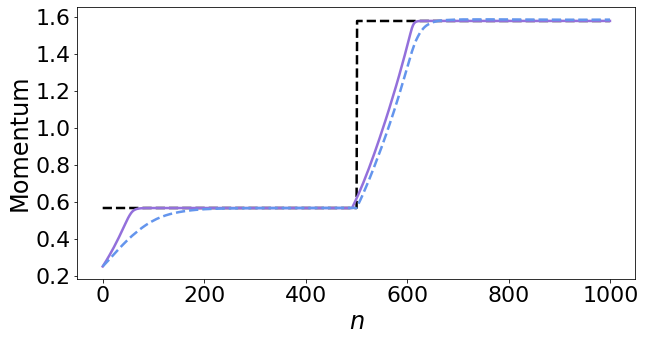

In [29]:

plt.figure(figsize=(10, 5))
plt.plot(momentum_ref, label="Reference", linestyle="--", color=ref_color, linewidth=linewidth)

plt.plot(
    pk_kdv_opt_momentum_5,
    label=r"$Ours(\lambda = 0.005)$",
    color=pk_curve, 
    linestyle=pk_linestyle, 
    linewidth=linewidth
)

plt.plot(
    vanilla_kdv_opt_momentum_5,
    label=r"$Vanilla(\lambda = 0.005)$",
    color=vanilla_curve, 
    linestyle=vanilla_linestyle, 
    linewidth=linewidth
)


plt.xticks(fontsize=ticks_font)
plt.yticks(fontsize=ticks_font)
plt.xlabel(r"$n$", fontsize=label_font)
plt.ylabel("Momentum", fontsize=label_font)


# plt.legend(fontsize=legend_font, loc=(1.05, 0.001))


# plt.savefig(os.path.join(figures_path, str(Nx)+'kdv_'+forcing_type+'_momentum_tracking_tau'+str(tau)+'.png'), dpi=200, bbox_inches='tight')
# plt.savefig(os.path.join(figures_path, str(Nx)+'kdv_'+forcing_type+'_momentum_tracking_tau'+str(tau)+'.pdf'), dpi=200, bbox_inches='tight')

# plt.close()


# Save data

In [37]:
# import pandas as pd
# results_dict = {
#             'pk_kdv_opt_momentum_5': pk_kdv_opt_momentum_5,
#             'momentum_ref':momentum_ref,
#             'vanilla_kdv_opt_momentum_5': vanilla_kdv_opt_momentum_5,
#             'pk_t_list_momentum_5': pk_t_list_momentum_5,
#             'vanilla_t_list_momentum_5': vanilla_t_list_momentum_5
# }


# np.save(os.path.join(weights_path,'check_vanilla_'+str(Nx)+'.npy'), results_dict)
# results_dict_list_vanilla_momentum_5 = [dict(result) for result in vanilla_results_momentum_5]
# results_dict_list_vanilla_momentum_5_df = pd.DataFrame(results_dict_list_vanilla_momentum_5)
# results_dict_list_vanilla_momentum_5_df.to_csv(os.path.join(weights_path,'opt_results_vanilla_'+str(Nx)+'.csv'), index=False)



# results_dict_list_pk_momentum_5 = [dict(result) for result in pk_results_momentum_5]
# results_dict_list_pk_momentum_5_df = pd.DataFrame(results_dict_list_pk_momentum_5)
# results_dict_list_pk_momentum_5_df.to_csv(os.path.join(weights_path,'opt_results_pk_'+str(Nx)+'.csv'), index=False)



In [28]:
# import pandas as pd
# import os
# file_path = os.path.join(weights_path, 'check_vanilla_' + str(Nx) + '.npy')
# results_dict = np.load(file_path, allow_pickle=True).item()

# pk_kdv_opt_momentum_5 = results_dict['pk_kdv_opt_momentum_5']
# # vanilla_kdv_opt_momentum_5 = results_dict['vanilla_kdv_opt_momentum_5']
# momentum_ref = results_dict['momentum_ref']
# pk_t_list_momentum_5 = results_dict['pk_t_list_momentum_5']
# # vanilla_t_list_momentum_5 = results_dict['vanilla_t_list_momentum_5']
# import pandas as pd
# results_dict = {
#             'pk_kdv_opt_momentum_5': pk_kdv_opt_momentum_5,
#             'vanilla_kdv_opt_momentum_5': vanilla_kdv_opt_momentum_5,
#             'momentum_ref':momentum_ref,
#             'pk_t_list_momentum_5': pk_t_list_momentum_5,
#             'vanilla_t_list_momentum_5': vanilla_t_list_momentum_5
# }


# np.save(os.path.join(weights_path,'check_vanilla_'+str(Nx)+'.npy'), results_dict)
# results_dict_list_vanilla_momentum_5 = [dict(result) for result in vanilla_results_momentum_5]
# results_dict_list_vanilla_momentum_5_df = pd.DataFrame(results_dict_list_vanilla_momentum_5)
# results_dict_list_vanilla_momentum_5_df.to_csv(os.path.join(weights_path,'opt_results_vanilla_'+str(Nx)+'.csv'), index=False)

